In [1]:
# Imports

import os
import re
import gzip
import pandas as pd
import numpy as np

# Data Container and Analysis
import anndata as ad
import scanpy as sc
import squidpy as sq

# Machine Learning and Visualization
from IPython.display import display
import matplotlib.pyplot as plt
plt.style.use("default")

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import umap

# CellPLM
from CellPLM.pipeline.cell_type_annotation import CellTypeAnnotationPipeline
from CellPLM.pipeline.cell_embedding import CellEmbeddingPipeline

# Environment Configuration (CUDA check)
import torch
if not torch.cuda.is_available():
    torch_load_old = torch.load
    def torch_load_cpu(*args, **kwargs):
        kwargs['map_location'] = torch.device('cpu')
        return torch_load_old(*args, **kwargs)
    torch.load = torch_load_cpu
    print("Running on CPU mode (CUDA not available).")

/Users/jleto/Library/Python/3.12/lib/python/site-packages/scanpy/_utils/__init__.py:33: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  from anndata import __version__ as anndata_version
/Users/jleto/Library/Python/3.12/lib/python/site-packages/scanpy/__init__.py:24: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  if Version(anndata.__version__) >= Version("0.11.0rc2"):
/Users/jleto/Library/Python/3.12/lib/python/site-packages/scanpy/readwrite.py:16: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  if Version(anndata.__version__) >= Version("0.11.0rc2"):
/Users/jleto/Library/Python/3.12/lib/python/site-packages/louvain/__init__.py:54: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using t

Running on CPU mode (CUDA not available).


In [2]:
# LOAD PREPROCESSED ANNDATA FROM NOTEBOOK 1

import anndata as ad
import scanpy as sc
import numpy as np
import pandas as pd

# Load the saved file created in Notebook 1
adata = ad.read_h5ad("adata_preprocessed.h5ad")

print("\nLoaded AnnData:")
print(adata)
print("Shape:", adata.shape)

# Quick sanity checks
print("\nAvailable layers:", list(adata.layers.keys()))
print("First few obs columns:", adata.obs.columns[:5])
print("First few var columns:", adata.var.columns[:5])


Loaded AnnData:
AnnData object with n_obs × n_vars = 9989 × 24377
    obs: 'sample_id', 'batch'
    var: 'n_cells'
    uns: 'log1p'
    layers: 'counts'
Shape: (9989, 24377)

Available layers: ['counts']
First few obs columns: Index(['sample_id', 'batch'], dtype='object')
First few var columns: Index(['n_cells'], dtype='object')


### 4. CellPLM

CellPLM is a transformer-based model trained on large-scale single-cell and spatial transcriptomics data to learn generalizable biological representations.
Instead of manually computing features through methods like PCA, CellPLM encodes each gene-expression profile into a dense vector, or embedding, that captures higher-level biological relationships between genes and cell states.

Each spot in the dataset is transformed into one of these embeddings, allowing spots with similar transcriptional patterns to appear close together in the embedding space, even if the relationships are complex or nonlinear.

In [3]:
# Run CellPLM

from CellPLM.pipeline.cell_type_annotation import CellTypeAnnotationPipeline
from CellPLM.pipeline.cell_embedding import CellEmbeddingPipeline
import anndata as ad

# CellPLM expects the normalized matrix (adata.X)
# Retrieve the correct UN-SCALED normalized matrix (X)
x_input = adata.copy() 

# initialize the pretrained model
pipeline = CellEmbeddingPipeline(
    pretrain_prefix="20230926_85M",
    pretrain_directory="ckpt/"
)
embeddings = pipeline.predict(x_input) # get embeddings
adata.obsm['X_cellplm'] = embeddings.detach().cpu().numpy()

/var/folders/nk/vwtp7n_53_18f4kxcylrscmm0000gn/T/ipykernel_94522/1457720667.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch_load_old(*args, **kwargs)
Input

Automatically converting gene symbols to ensembl ids...


540 input query terms found dup hits:	[('LINC00115', 2), ('LINC01786', 2), ('SLC35E2A', 2), ('TNFRSF14-AS1', 3), ('LINC01672', 2), ('CAMTA
6087 input query terms found no hit:	['AL627309.1', 'AL627309.5', 'AL645608.2', 'AL645608.7', 'AL391244.2', 'TMEM88B', 'AL645728.1', 'AL6
/Users/jleto/Library/Python/3.12/lib/python/site-packages/CellPLM/utils/data.py:20: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/SparseCsrTensorImpl.cpp:55.)
  return torch.sparse_csr_tensor(x.indptr, x.indices, x.data, (x.shape[0], x.shape[1])).to_sparse().float().coalesce()


After filtering, 15114 genes remain.


In [4]:
# CellPLM converts each spot's gene-expression profile into a numerical vector
# (embedding). Each embedding has 512 values that summarize patterns in the
# data, similar to how PCA produces principal components.

# The difference is that CellPLM learns these 512 features using a large
# pretrained model instead of simple linear variance.

print(embeddings.shape)
print(embeddings[:5])

torch.Size([9989, 512])
tensor([[ 0.1830, -0.0135,  0.0538,  ..., -0.8781, -0.1047, -0.0396],
        [ 0.1768, -0.0091,  0.0583,  ..., -0.8785, -0.0613, -0.0539],
        [ 0.1967, -0.0128,  0.0333,  ..., -0.8860, -0.1205, -0.0485],
        [ 0.1954, -0.0158,  0.0619,  ..., -0.8739, -0.0907, -0.0421],
        [ 0.1924, -0.0121,  0.0470,  ..., -0.8838, -0.0993, -0.0473]])


/Users/jleto/Library/Python/3.12/lib/python/site-packages/scanpy/neighbors/__init__.py:430: FutureWarning: Use obsm (e.g. `k in adata.obsm` or `adata.obsm.keys() | {'u'}`) instead of AnnData.obsm_keys, AnnData.obsm_keys is deprecated and will be removed in the future.
  if "X_diffmap" in adata.obsm_keys():
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


CellPLM Nearest-Neighbor Graph complete.
CellPLM K-Means clustering complete with 7 clusters.


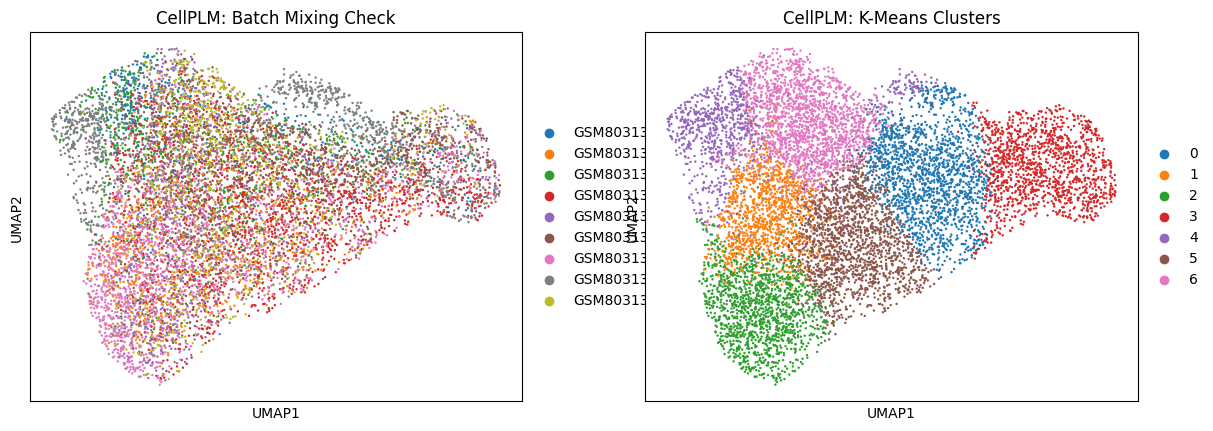

In [5]:
# Compute the Nearest-Neighbor Graph on CellPLM Embeddings

# This graph is the foundational structure required for UMAP
# We use the CellPLM embeddings as input for this structure.
sc.pp.neighbors(
    adata, 
    use_rep='X_cellplm',  # Correct input
    n_neighbors=15 
)

print("CellPLM Nearest-Neighbor Graph complete.")

# UMAP Projection, Clustering (K-Means), and Validation Plot

# K-Means Clustering

# Use the CellPLM embeddings as input
X_input = adata.obsm['X_cellplm']

n_clusters_to_use = 7 

from sklearn.cluster import KMeans
import numpy as np

kmeans = KMeans(n_clusters=n_clusters_to_use, random_state=0, n_init='auto')

# Store results in a UNIQUE column for CellPLM
adata.obs['kmeans_cellplm'] = kmeans.fit_predict(X_input).astype(str) 

print(f"CellPLM K-Means clustering complete with {n_clusters_to_use} clusters.")

# Run UMAP
# UMAP relies on the CellPLM-based Graph calculated above
sc.tl.umap(adata)

# Generate Validation Plot
sc.pl.umap(
    adata, 
    # CRITICAL FIX: Color by the NEW 'kmeans_cellplm' column, not the old 'kmeans'
    color=['batch', 'kmeans_cellplm'], 
    ncols=2,
    # Update filename to avoid overwriting the Harmony plot
    save='_kmeans_cellplm_validation.png', 
    title=['CellPLM: Batch Mixing Check', 'CellPLM: K-Means Clusters']
)

### Extra: Load JSON Files

The provided JSON files contain the spatial metadata for every Visium spot on each slide, including coordinates and whether the spot actually overlaps tissue. Some spots fall on empty areas of the slide and have no meaningful expression data. After loading the JSON files, we keep only the spots marked as tissue=True so downstream analysis focuses on real biological material.

Filtering to tissue-only spots also ensures that the remaining rows line up with the expression matrix, meaning each spatial entry corresponds directly to the same spot in the data.

In [6]:
# Load JSON Files — Spatial Coordinates and Metadata Per Spot

import gzip, json, pandas as pd
from pathlib import Path

data_dir = "GSE253975_data"
print(os.listdir(data_dir))

json_dir = Path(data_dir)
json_files = sorted(json_dir.glob("*.json.gz"))

coords_list = []

for file_path in json_files:
    sample_id = file_path.stem.split("_")[0]  # e.g. GSM8031360
    with gzip.open(file_path, "rt") as f:
        data = json.load(f)
        oligos = pd.DataFrame(data["oligo"])
        oligos["sample_id"] = sample_id
        coords_list.append(oligos)

coords_df = pd.concat(coords_list, ignore_index=True)
coords_df = coords_df.rename(columns={"imageX": "x_coord", "imageY": "y_coord"})

coords_df.head()

['GSM8031369_T2465.txt.gz', 'GSM8031368_V11U14-042-C1.json.gz', 'GSM8031367_V11U14-040-A1.json.gz', 'GSM8031363_T2791.txt.gz', 'GSM8031364_V11U14-040-C1.json.gz', 'GSM8031361_V11U14-042-A1.json.gz', 'GSM8031361_T0081.txt.gz', 'GSM8031364_T5498.txt.gz', 'GSM8031362_V11U14-042-D1.json.gz', 'GSM8031368_T3799.txt.gz', 'GSM8031366_V11U14-044-C1.json.gz', 'GSM8031365_V11U14-044-A1.json.gz', 'GSM8031362_T3870.txt.gz', 'GSM8031363_V11U14-042-B1.json.gz', 'combined_metadata.json', 'GSM8031367_T4424.txt.gz', 'GSM8031366_T5359.txt.gz', 'GSM8031369_V11U14-040-B1.json.gz', 'GSM8031365_T4839.txt.gz']


,x,y,row,col,dia,x_coord,y_coord,tissue,sample_id
0,4825,30073,0,0,53.25297,5938.0490,5803.2710,NaN,GSM8031361
1,4875,30160,1,1,53.25297,5866.8457,5762.1787,NaN,GSM8031361
2,4925,30073,0,2,53.25297,5938.1963,5721.3433,NaN,GSM8031361
3,4975,30160,1,3,53.25297,5866.9937,5680.2510,NaN,GSM8031361
4,5025,30073,0,4,53.25297,5938.3440,5639.4160,NaN,GSM8031361


In [7]:
# Filter out spots that do not actually contain tissue.
# 'tissue=True' marks spots where RNA was captured, so keeping only these
# ensures we work with meaningful spatial data

coords_tissue = coords_df[coords_df["tissue"] == True].copy()

print("Coords Tissue Shape:", coords_tissue.shape)
coords_tissue.head()

Coords Tissue Shape: (9989, 9)


,x,y,row,col,dia,x_coord,y_coord,tissue,sample_id
1303,5975,31900,21,23,53.25297,4442.9326,4858.4043,True,GSM8031361
1304,6025,31813,20,24,53.25297,4514.2837,4817.5690,True,GSM8031361
1305,6075,31900,21,25,53.25297,4443.0806,4776.4766,True,GSM8031361
1306,6125,31813,20,26,53.25297,4514.4310,4735.6416,True,GSM8031361
1307,6175,31900,21,27,53.25297,4443.2285,4694.5493,True,GSM8031361


In [8]:
# Ensure the number of spots matches exactly before merging
if adata.n_obs != coords_tissue.shape[0]:
    print(f"Mismatch: AnnData has {adata.n_obs} spots, but Coords has {coords_tissue.shape[0]}.")
    print("Please ensure both are sorted by Sample ID before merging.")
else:
    print(f"Spot counts match ({adata.n_obs}). Proceeding with merge...")

    # Assign Spatial Coordinates
    # T ake the x and y image coordinates from the dataframe
    # AnnData expects this as a numpy array in .obsm['spatial']
    adata.obsm['spatial'] = coords_tissue[['x_coord', 'y_coord']].values

    # Add other metadata from the JSONs to adata.obs
    adata.obs['array_row'] = coords_tissue['row'].values
    adata.obs['array_col'] = coords_tissue['col'].values

    print("Spatial coordinates successfully added to adata.obsm['spatial'].")

Spot counts match (9989). Proceeding with merge...
Spatial coordinates successfully added to adata.obsm['spatial'].


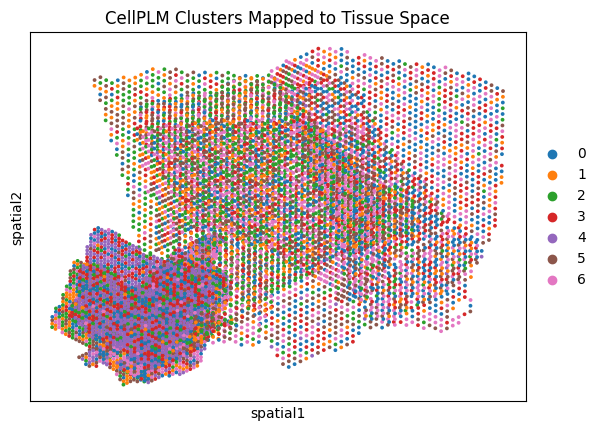

In [9]:
# Spatial Visualization of CellPLM Clusters

# We use 'embedding' with basis='spatial' to plot the coordinates loaded manually.
sc.pl.embedding(
    adata,
    basis="spatial",
    color="kmeans_cellplm", 
    size=30, # Note: parameter is 'size', not 'spot_size' for embeddings
    title="CellPLM Clusters Mapped to Tissue Space",
    save="_cellplm_spatial_map.png"
)
